In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 75 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
bouncing_ball_step = combinators.PrimitiveCall(bouncing_ball.bouncing_ball_step)

In [8]:
prior_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [9]:
init_bouncing_ball = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles, hyper=prior_init_params)

In [10]:
bouncing_ball_smc = importance.reduce_smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_bouncing_ball)

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.ones(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce(Foldable(bouncing_ball_step))/0/init_bouncing_ball/position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce(Foldable(bouncing_ball_step))/%d/Foldable(bouncing_ball_step)(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

01/02/2019 17:09:11 EUBO=8.65326904e+02 at epoch 1
01/02/2019 17:09:11 EUBO=6.44795837e+02 at epoch 2
01/02/2019 17:09:12 EUBO=6.07595703e+02 at epoch 3
01/02/2019 17:09:12 EUBO=6.94341919e+02 at epoch 4
01/02/2019 17:09:13 EUBO=6.32353210e+02 at epoch 5
01/02/2019 17:09:13 EUBO=6.39385254e+02 at epoch 6
01/02/2019 17:09:14 EUBO=5.12184265e+02 at epoch 7
01/02/2019 17:09:14 EUBO=4.41084473e+02 at epoch 8
01/02/2019 17:09:15 EUBO=4.08707428e+02 at epoch 9
01/02/2019 17:09:15 EUBO=5.66371887e+02 at epoch 10
01/02/2019 17:09:16 EUBO=3.29009399e+02 at epoch 11
01/02/2019 17:09:16 EUBO=5.31806763e+02 at epoch 12
01/02/2019 17:09:17 EUBO=5.05536194e+02 at epoch 13
01/02/2019 17:09:17 EUBO=3.60888702e+02 at epoch 14
01/02/2019 17:09:18 EUBO=2.40256775e+02 at epoch 15
01/02/2019 17:09:18 EUBO=3.15089722e+02 at epoch 16
01/02/2019 17:09:19 EUBO=4.12709991e+02 at epoch 17
01/02/2019 17:09:19 EUBO=3.48244476e+02 at epoch 18
01/02/2019 17:09:20 EUBO=3.68410278e+02 at epoch 19
01/02/2019 17:09:21 E

Epoch   350: reducing learning rate of group 0 to 5.0000e-03.


01/02/2019 17:12:08 EUBO=2.39515564e+02 at epoch 352
01/02/2019 17:12:08 EUBO=1.51505295e+02 at epoch 353
01/02/2019 17:12:09 EUBO=2.29388672e+02 at epoch 354
01/02/2019 17:12:09 EUBO=2.23398056e+02 at epoch 355
01/02/2019 17:12:10 EUBO=2.30132797e+02 at epoch 356
01/02/2019 17:12:10 EUBO=2.10972244e+02 at epoch 357
01/02/2019 17:12:11 EUBO=1.73706848e+02 at epoch 358
01/02/2019 17:12:11 EUBO=2.63853607e+02 at epoch 359
01/02/2019 17:12:12 EUBO=1.53573074e+02 at epoch 360
01/02/2019 17:12:12 EUBO=2.81008881e+02 at epoch 361
01/02/2019 17:12:13 EUBO=1.78951431e+02 at epoch 362
01/02/2019 17:12:13 EUBO=2.71143890e+02 at epoch 363
01/02/2019 17:12:14 EUBO=1.29992874e+02 at epoch 364
01/02/2019 17:12:14 EUBO=1.37933380e+02 at epoch 365
01/02/2019 17:12:15 EUBO=5.01512527e+01 at epoch 366
01/02/2019 17:12:15 EUBO=2.42510986e+02 at epoch 367
01/02/2019 17:12:16 EUBO=9.02848358e+01 at epoch 368
01/02/2019 17:12:16 EUBO=5.73403702e+01 at epoch 369
01/02/2019 17:12:17 EUBO=2.42149063e+02 at epo

Epoch   551: reducing learning rate of group 0 to 2.5000e-03.


01/02/2019 17:13:47 EUBO=2.32466705e+02 at epoch 553
01/02/2019 17:13:47 EUBO=2.48702148e+02 at epoch 554
01/02/2019 17:13:48 EUBO=2.70801819e+02 at epoch 555
01/02/2019 17:13:48 EUBO=9.59765701e+01 at epoch 556
01/02/2019 17:13:49 EUBO=1.28685675e+01 at epoch 557
01/02/2019 17:13:49 EUBO=2.79766632e+02 at epoch 558
01/02/2019 17:13:50 EUBO=2.37272095e+02 at epoch 559
01/02/2019 17:13:50 EUBO=1.65171875e+02 at epoch 560
01/02/2019 17:13:51 EUBO=7.67302628e+01 at epoch 561
01/02/2019 17:13:51 EUBO=2.29525482e+02 at epoch 562
01/02/2019 17:13:52 EUBO=2.49566452e+02 at epoch 563
01/02/2019 17:13:52 EUBO=2.08860748e+02 at epoch 564
01/02/2019 17:13:53 EUBO=1.87705978e+02 at epoch 565
01/02/2019 17:13:53 EUBO=2.19926147e+02 at epoch 566
01/02/2019 17:13:54 EUBO=2.22551529e+02 at epoch 567
01/02/2019 17:13:54 EUBO=2.74899109e+02 at epoch 568
01/02/2019 17:13:55 EUBO=2.05436462e+02 at epoch 569
01/02/2019 17:13:55 EUBO=2.65099243e+02 at epoch 570
01/02/2019 17:13:56 EUBO=1.86151077e+02 at epo

Epoch   752: reducing learning rate of group 0 to 1.2500e-03.


01/02/2019 17:15:27 EUBO=1.31801682e+02 at epoch 754
01/02/2019 17:15:27 EUBO=1.82440186e+02 at epoch 755
01/02/2019 17:15:28 EUBO=1.96870361e+02 at epoch 756
01/02/2019 17:15:28 EUBO=1.94507507e+02 at epoch 757
01/02/2019 17:15:28 EUBO=1.85700455e+02 at epoch 758
01/02/2019 17:15:29 EUBO=2.09660080e+02 at epoch 759
01/02/2019 17:15:29 EUBO=1.50655365e+02 at epoch 760
01/02/2019 17:15:30 EUBO=2.62540344e+02 at epoch 761
01/02/2019 17:15:30 EUBO=2.65606201e+02 at epoch 762
01/02/2019 17:15:31 EUBO=2.38879547e+02 at epoch 763
01/02/2019 17:15:31 EUBO=1.97613235e+02 at epoch 764
01/02/2019 17:15:32 EUBO=2.01888550e+02 at epoch 765
01/02/2019 17:15:32 EUBO=2.13281769e+02 at epoch 766
01/02/2019 17:15:33 EUBO=1.70336044e+02 at epoch 767
01/02/2019 17:15:33 EUBO=2.65850586e+02 at epoch 768
01/02/2019 17:15:34 EUBO=2.88416595e+02 at epoch 769
01/02/2019 17:15:34 EUBO=9.32531509e+01 at epoch 770
01/02/2019 17:15:35 EUBO=7.67980118e+01 at epoch 771
01/02/2019 17:15:35 EUBO=-9.13832951e+00 at ep

Epoch   953: reducing learning rate of group 0 to 6.2500e-04.


01/02/2019 17:17:08 EUBO=3.29166718e+02 at epoch 955
01/02/2019 17:17:09 EUBO=2.24282639e+02 at epoch 956
01/02/2019 17:17:09 EUBO=2.67464966e+02 at epoch 957
01/02/2019 17:17:10 EUBO=2.60328857e+02 at epoch 958
01/02/2019 17:17:10 EUBO=2.61791809e+02 at epoch 959
01/02/2019 17:17:11 EUBO=1.64372452e+02 at epoch 960
01/02/2019 17:17:11 EUBO=1.98026276e+02 at epoch 961
01/02/2019 17:17:12 EUBO=1.82724457e+02 at epoch 962
01/02/2019 17:17:12 EUBO=2.70109131e+02 at epoch 963
01/02/2019 17:17:13 EUBO=1.92339233e+02 at epoch 964
01/02/2019 17:17:13 EUBO=1.19915237e+02 at epoch 965
01/02/2019 17:17:14 EUBO=2.49481903e+02 at epoch 966
01/02/2019 17:17:14 EUBO=2.27236099e+02 at epoch 967
01/02/2019 17:17:15 EUBO=1.72289581e+02 at epoch 968
01/02/2019 17:17:15 EUBO=2.40615753e+02 at epoch 969
01/02/2019 17:17:16 EUBO=2.37024109e+02 at epoch 970
01/02/2019 17:17:16 EUBO=2.20194290e+02 at epoch 971
01/02/2019 17:17:17 EUBO=1.54407150e+02 at epoch 972
01/02/2019 17:17:17 EUBO=9.97536087e+01 at epo

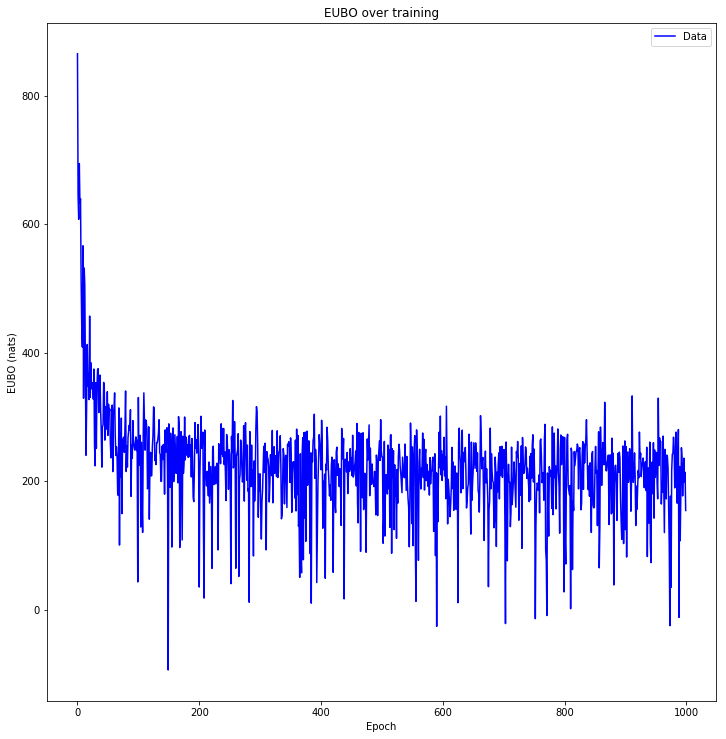

MSE at time 0: 29.808950
MSE at time 1: 27.481129
MSE at time 2: 36.498581
MSE at time 3: 42.417004
MSE at time 4: 40.393036
MSE at time 5: 42.857914
MSE at time 6: 50.560284
MSE at time 7: 46.135761
MSE at time 8: 41.630451
MSE at time 9: 46.099022
MSE at time 10: 37.763508
MSE at time 11: 42.219597
MSE at time 12: 41.724083
MSE at time 13: 46.073891
MSE at time 14: 35.152584
MSE at time 15: 33.952568
MSE at time 16: 25.548162
MSE at time 17: 15.904922
MSE at time 18: 12.489413
MSE at time 19: 10.651596
MSE at time 20: 4.700564
MSE at time 21: 3.829791
MSE at time 22: 5.301333
MSE at time 23: 8.569723
MSE at time 24: 8.760297
MSE at time 25: 17.851383
MSE at time 26: 23.280588
MSE at time 27: 31.413416
MSE at time 28: 41.811607
MSE at time 29: 53.088737
MSE at time 30: 68.143333
MSE at time 31: 67.556198
MSE at time 32: 80.630669
MSE at time 33: 96.740608
MSE at time 34: 99.763130
MSE at time 35: 106.362030
MSE at time 36: 113.722008
MSE at time 37: 117.762627
MSE at time 38: 99.38407

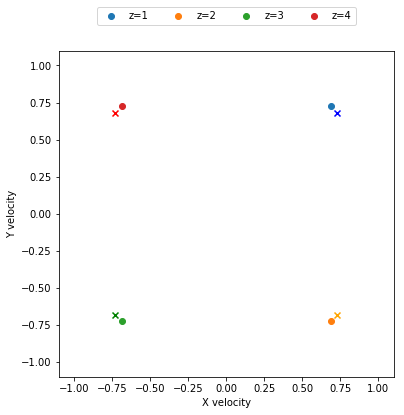

In [17]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    init_proposal = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles,
                                                trainable=variational_init_params)
    bouncing_ball_proposal = foldable.Reduce(foldable.Foldable(bouncing_ball_step, initializer=init_proposal), lambda: range(T))
    
    importance_sampler = combinators.score_under_proposal(bouncing_ball_smc, bouncing_ball_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-2, inclusive_kl=True,
        patience=200,
    )
    trained_params = init_proposal.args_vardict()
    utils.plot_evidence_bounds(eubos, False)
    
    init_posterior = combinators.PrimitiveCall(bouncing_ball.init_bouncing_ball,
                                               hyper=trained_params)
    bouncing_ball_posterior = importance.reduce_smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_posterior)
    _, inference, _ = bouncing_ball_posterior.simulate()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce(Foldable(bouncing_ball_step))/%d/Foldable(bouncing_ball_step)(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    alpha = torch.tensor(trained_params['directions']['angle']['concentration1']).mean(dim=0)
    beta = torch.tensor(trained_params['directions']['angle']['concentration0']).mean(dim=0)
    mean_angle = torch.distributions.Beta(alpha, beta).mean  * np.pi/2
    modal_directions[s] = bouncing_ball.reflect_directions(mean_angle)
    mean_angle = inference['Reduce(Foldable(bouncing_ball_step))/0/init_bouncing_ball/directions__angle'].value.mean(dim=0).detach().cpu() * np.pi/2
    final_mus[s] = bouncing_ball.reflect_directions(mean_angle).numpy()
    final_covs[s] = inference['Reduce(Foldable(bouncing_ball_step))/0/init_bouncing_ball/directions__scale'].value.mean(dim=0).detach().cpu().numpy()
    for k in range(K):
        As_pred[s][k] = inference['Reduce(Foldable(bouncing_ball_step))/0/init_bouncing_ball/A_%d' % (k+1)].value.mean(dim=0).detach().cpu().numpy()
    
    plt.close('all')
    
    for t in range(T):
        accuracy = ((trajectory[t+1, :2] - positions[t])**2).mean()
        print('MSE at time %d: %f' % (t, accuracy))

graph_velocity_frequencies(modal_directions.detach().numpy())

In [18]:
import bouncing_ball_plots

In [19]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

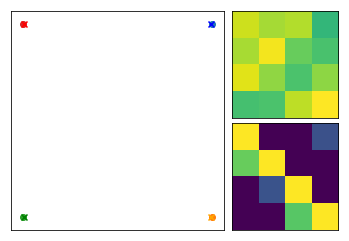

In [20]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

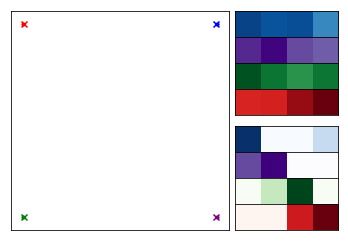

In [21]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [22]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

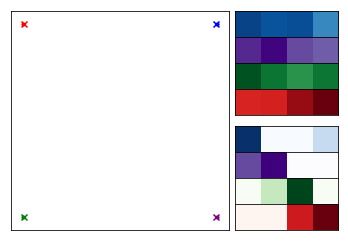

In [23]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)